In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 409.0 kB/s eta 0:00:00m eta 0:00:010:00:10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 514.5 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 185.1 kB/s eta 0:00:001m168.5 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 187.8 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 1.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 1.8 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 952.7 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━

In [23]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from scipy import signal
from scipy.signal import butter, filtfilt, iirnotch, periodogram

In [17]:
import os
os.getcwd()

'c:\\Users\\aryan\\Documents\\GitHub\\ecz-ware\\training'

In [45]:
df_scratch = pd.read_csv('data\\emg_scratch.csv')
df_rest = pd.read_csv('data\\emg_rest.csv')
df_other = pd.read_csv('data\\emg_other.csv')
df_scratch

,timestamp,v1,v2,label
0,1752471222,1.508,1.633,1
1,1752471222,1.532,1.742,1
2,1752471222,1.504,1.654,1
3,1752471222,1.534,1.758,1
4,1752471222,1.506,1.628,1
...,...,...,...,...
1495,1752471233,1.447,1.580,1
1496,1752471233,1.409,1.716,1
1497,1752471233,1.519,1.577,1
1498,1752471233,1.478,1.699,1


In [46]:
scratch_data = df_scratch['v2'].to_numpy()
other_data = df_other['v2'].to_numpy()
rest_data = df_rest['v2'].to_numpy()

In [47]:
def cleanup(data):
    data = data - np.mean(data)
    data = (data - data.min()) / (data.max() - data.min())
    return data

def bandpass_filter(data, lowcut=20.0, highcut=90.0, fs=200.0, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data)

def find_noise_frequency(data, fs=200.0):
    f, Pxx = periodogram(data, fs=fs)
    idx = np.argmax(Pxx)
    return f[idx]

def adaptive_notch_filter(data, fs=200.0, quality=30):
    freq = find_noise_frequency(data, fs=fs)
    nyq = 0.5 * fs
    b, a = iirnotch(freq/nyq, quality)
    return filtfilt(b, a, data)

In [48]:
def get_spectrogram(data: np.ndarray):
    f, t, z = signal.stft(data, fs=200, nperseg=128, noverlap=50, nfft=128)
    spectrogram = np.abs(z)
    return f, t, spectrogram

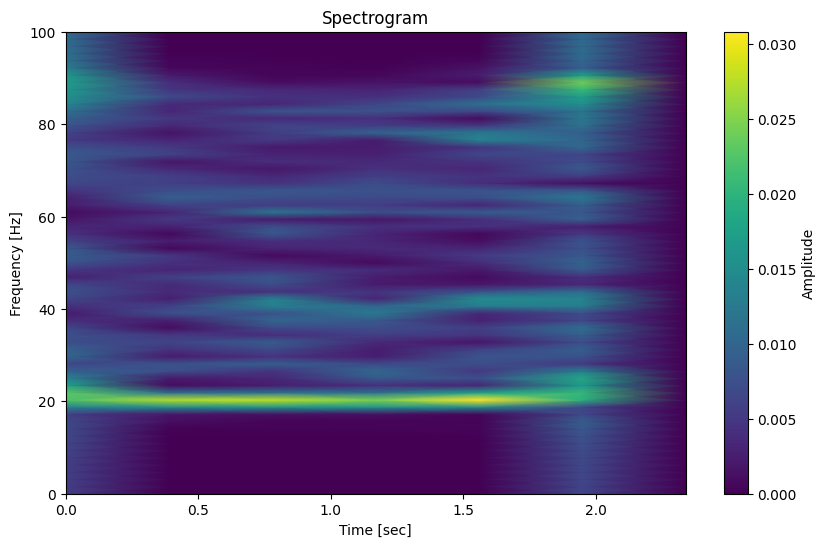

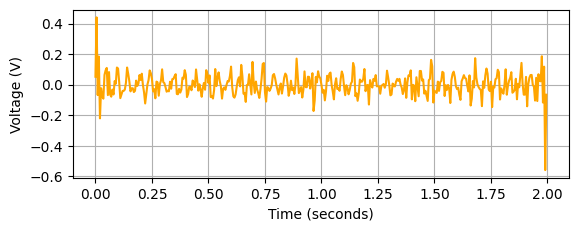

In [57]:
current_array = rest_data[0:400]
cleaned = cleanup(current_array)
cleaned = bandpass_filter(cleaned)
cleaned = adaptive_notch_filter(cleaned)
f, t, s = get_spectrogram(cleaned)
# print(f, t)
plt.figure(figsize=(10, 6))
plt.pcolormesh(t, f, s, shading='gouraud')
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Amplitude')  # limit frequency range to make plot clearer
plt.show()

time = np.arange(len(current_array)) / 200.0  

plt.subplot(2, 1, 2)
plt.plot(time, cleaned, label='Centered EMG Voltage', color='orange')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (seconds)')

plt.grid(True)